<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Before-running-the-notebook" data-toc-modified-id="Before-running-the-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Before running the notebook</a></span></li><li><span><a href="#Generation" data-toc-modified-id="Generation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generation</a></span></li><li><span><a href="#XOR" data-toc-modified-id="XOR-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>XOR</a></span></li><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize results</a></span></li><li><span><a href="#MT" data-toc-modified-id="MT-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>MT</a></span></li><li><span><a href="#SR" data-toc-modified-id="SR-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SR</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import numpy as np
import pandas as pd
import scipy.special as ss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

module_path = os.path.abspath(os.path.join('./modules/'))
scripts_path = os.path.abspath(os.path.join('./scripts/'))
sys.path.append(module_path)
sys.path.append(scripts_path)

np.seterr(all='ignore')
ss.seterr(all='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

from main import main as infer
from generate_graph import main as generate
from compute_metrics import membership_metrics, normalize_nonzero_membership, calculate_AUC

In [2]:
cmap = 'PuBuGn'

def extract_overlapping_membership(i, cm, U, threshold=0.1):
    groups = np.where(U[i] > threshold)[0]
    wedge_sizes = U[i][groups]
    wedge_colors = [cm(c) for c in groups]
    return wedge_sizes, wedge_colors

def normalize_nonzero_membership(U):
    den1 = U.sum(axis=1, keepdims=True)
    nzz = den1 == 0.
    den1[nzz] = 1.
    return U / den1

# Before running the notebook

- Modify the _generation_ setting file inserting the right output path, e.g. <code>folder: "../data/input/"</code>;
- Modify the _generation_ setting file inserting the right output path, e.g. <code>label: "test"</code>;
- Modify the _inference_ setting file inserting the right output path, e.g. <code>folder: "../data/output/XOR/"</code>;
- Modify the _inference_ setting file choosing the right flag value for outputting results, e.g. <code>output_inference: True</code>;
- Modify the _cells_ defining the <code>args</code> dictionary inserting the desired input for the <code>generate</code>  and <code>infer</code> functions.

# Generation

Graphs realizations are drawn from the specified distribution; here self loops are allowed.

In [3]:
gen_args = {
            'min_ratio': 0.8,                          # bottom value for the range of interest for mu
            'max_ratio': np.nan,                       # top value for the range of interest for mu
            'step_ratio': np.nan,                      # stepsize value for the range of interest for mu
            'samples': 1,                              # number of samples to be drawn for each set of params
            'settings': './setting_syn_XOR.yaml'       # path to the setting file to be used
            }

In [4]:
generate(gen_args)


--- Generating with XOR model ---
Number of links in the upper triangular matrix: 316
Number of links in the lower triangular matrix: 262
Sum of weights in the upper triangular matrix: 452
Sum of weights in the lower triangular matrix: 386
Removed 0 nodes, because not part of the largest connected component
Number of nodes: 100 
Number of edges: 600
Average degree (E/N): 6.0
Average weighted degree (M/N): 8.66

Parameters saved in: ../../data/input/results_test_r0.8_XOR_112.npz
To load: theta=np.load(filename), then e.g. theta["u"]
Adjacency matrix saved in: ../../data/input/syn_test_r0.8_XOR_112.dat


In [5]:
in_folder = '../data/input'
theta_GT = np.load(f'{in_folder}/results_test_r0.8_XOR_112.npz')

# XOR

Data are loaded and preprocessed (e.g. self loops are removed); the XOR inference algorithm is run.

In [6]:
inf_args = {
            'adj' : 'syn_test_r0.8_XOR_112.dat',         # name of the network file
            'in_folder' : '../data/input/',              # folder of the input network
            'algorithm' : 'XOR',                         # the desired inference model
            'settings' : 'setting_XOR.yaml',             # complete path of the settings file
            'K' : 3,                                     # number of communities to infer
            'beta' : 5,                                  # inverse temperature parameter
            'NFold' : 5,                                 # number of folds to perform cross-validation
            'out_mask' : False                           # flag to output the masks
            }

In [7]:
# The model output function appends results to existing dataframe if it is found in memory.
# Delete if you want to avoid repetitions of lines or drop duplicates when loading.
! rm -r ../data/output/XOR

infer(inf_args)

../data/input/syn_test_r0.8_XOR_112.dat shape: (600, 3)
Number of nodes = 100
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 578 - <k> = 5.78
M[0] = 838 - <k_weighted> = 8.38

--- Run inference with XOR model ---



OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



Time elapsed: 6.99 seconds.


In [8]:
folder = '../data/output/XOR'
metrics = pd.read_csv(f'{folder}/metrics_test_r0.8_XOR_112_XOR.csv')
conv = metrics.convergence_out == True
best_seed = metrics[metrics[conv].logL_out == np.max(metrics[conv].logL_out)].seed_out.item()

theta = np.load(f'{folder}/parameters_test_r0.8_XOR_112_XOR_{str(best_seed)}.npz')

In [9]:
list(theta.keys())

['s',
 'c',
 'beta',
 'gamma',
 'u',
 'v',
 'w',
 'Q',
 'ratio',
 'delta0',
 'K',
 'nodes_s',
 'nodes_c']

In [10]:
print('Inferred % of nodes interacting with hierarchy:',theta['ratio'])
print('Ground truth % of nodes interacting with hierarchy:',theta_GT['sigma'].sum()/theta_GT['sigma'].shape[0])

Inferred % of nodes interacting with hierarchy: 0.8300000059979565
Ground truth % of nodes interacting with hierarchy: 0.83


# Visualize results

### Ground truth $\sigma$

In [11]:
theta_GT['sigma']

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

### Inferred $\sigma$

In [12]:
theta['Q'].astype('int')

array([[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]])

### Ranking

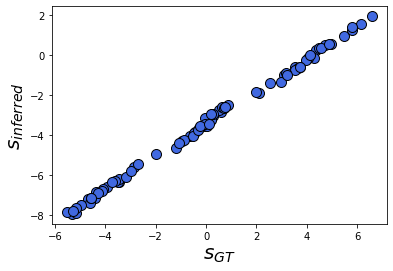

In [13]:
plt.figure()
plt.scatter(theta_GT['s'][theta_GT['sigma']==1],theta['s'][theta_GT['sigma']==1],s=100,c='royalblue',edgecolors='black')
plt.ylabel(r'$s_{inferred}$',fontsize=20)
plt.xlabel(r'$s_{GT}$',fontsize=20)
plt.show()

### Communities

#### Extract networks (for visualization)

In [14]:
import networkx as nx
from tools import import_data
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from compute_metrics import opt_permutation

In [15]:
G = import_data('../../data/input/syn_test_r0.8_XOR_112.dat', header=0)[0][0]

Gc = max(nx.weakly_connected_components(G), key=len)
nodes_to_remove = set(G.nodes()).difference(Gc)
G.remove_nodes_from(list(nodes_to_remove))

../../data/input/syn_test_r0.8_XOR_112.dat shape: (600, 3)
Number of nodes = 100
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 578 - <k> = 5.78
M[0] = 838 - <k_weighted> = 8.38


#### Plot network

In [16]:
from_list = LinearSegmentedColormap.from_list
cm = from_list('Set15', plt.cm.Set1(range(0,10)), 10)
cmap = cm

wedgeprops = {'edgecolor' : 'lightgrey'}

In [17]:
u_gt = normalize_nonzero_membership(theta_GT['u'])
u_inf = normalize_nonzero_membership(theta['u'])
N = u_gt.shape[0]
# Add one column for a dummy membership, this is for nodes with sigma_i=1
u_gt = np.hstack((u_gt,np.zeros((N,1)))) 
u_inf = np.hstack((u_inf,np.zeros((N,1)))) 
u_gt[np.where(theta_GT['sigma']==1)[0]] = 0
u_gt[np.where(theta_GT['sigma']==1)[0],-1] = 1
u_inf[np.where(theta['Q'][0]==1)[0],-1] = 1
# Permute so that groups GT correspond to inferred
u_inf = np.dot(u_inf, opt_permutation(u_inf, u_gt))  # permute on clusters (2nd dimension)

In [18]:
# Custom position, for better visualization
delta = 0.6
C = theta['u'].shape[1] +1
pos_groups = nx.circular_layout(nx.cycle_graph(C))
pos = {}
nodes = list(G.nodes())
for c, i in enumerate(nodes):
    r = np.random.rand() * 2 * np.math.pi
    radius = np.random.rand()
    pos[i] = pos_groups[np.argmax(u_gt[c])] + delta * radius * np.array([np.math.cos(r), np.math.sin(r)])

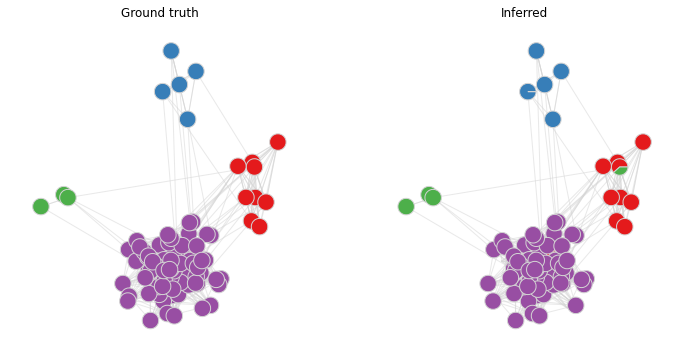

In [19]:
rad = 0.09
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
ax = plt.gca()
nx.draw_networkx_edges(G, pos,arrows=False, edge_color='lightgrey', alpha=0.5)
for n in list(G.nodes()):
    wedge_sizes, wedge_colors = extract_overlapping_membership(n, cm, u_gt, threshold=0.1)
    if len(wedge_sizes) > 0:
        pie,t = plt.pie(wedge_sizes, center=pos[n], colors=wedge_colors,
                        radius=rad, wedgeprops=wedgeprops, normalize=False)
ax.axis("equal")
plt.title('Ground truth')

plt.subplot(1, 2, 2)
ax = plt.gca()
nx.draw_networkx_edges(G, pos, arrows=False, edge_color='lightgrey', alpha=0.5)
for n in list(G.nodes()):
    wedge_sizes, wedge_colors = extract_overlapping_membership(n, cm, u_inf, threshold=0.1)
    if len(wedge_sizes) > 0:
        pie,t = plt.pie(wedge_sizes, center=pos[n], colors=wedge_colors,
                        radius=rad, wedgeprops=wedgeprops, normalize=False)
ax.axis("equal")
plt.title('Inferred')
plt.show()

# MT

In [20]:
inf_args = {
            'adj' : 'syn_test_r0.8_XOR_112.dat',         # name of the network file
            'in_folder' : '../data/input/',              # folder of the input network
            'algorithm' : 'MT',                          # the desired inference model
            'settings' : 'setting_MT.yaml',              # complete path of the settings file
            'K' : 3,                                     # number of communities to infer
            'beta' : 5,                                  # inverse temperature parameter
            'NFold' : 5,                                 # number of folds to perform cross-validation
            'out_mask' : False                           # flag to output the masks
            }

In [21]:
# The model output function appends results to existing dataframe if it is found in memory.
# Delete if you want to avoid repetitions of lines or drop duplicates when loading.
! rm -r ../data/output/MT

infer(inf_args)

../data/input/syn_test_r0.8_XOR_112.dat shape: (600, 3)
Number of nodes = 100
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 578 - <k> = 5.78
M[0] = 838 - <k_weighted> = 8.38

--- Run inference with MT model ---


Time elapsed: 0.93 seconds.


In [22]:
folder = '../data/output/MT'
metrics = pd.read_csv(f'{folder}/metrics_test_r0.8_XOR_112_MT.csv')
conv = metrics.convergence_out == True
best_seed = metrics[metrics[conv].logL_out == np.max(metrics[conv].logL_out)].seed_out.item()

theta_MT = np.load(f'{folder}/parameters_test_r0.8_XOR_112_MT_{str(best_seed)}.npz')

In [23]:
list(theta.keys())

['s',
 'c',
 'beta',
 'gamma',
 'u',
 'v',
 'w',
 'Q',
 'ratio',
 'delta0',
 'K',
 'nodes_s',
 'nodes_c']

# SR

In [24]:
inf_args = {
            'adj' : 'syn_test_r0.8_XOR_112.dat',         # name of the network file
            'in_folder' : '../data/input/',              # folder of the input network
            'algorithm' : 'SR',                          # the desired inference model
            'settings' : 'setting_SR.yaml',              # complete path of the settings file
            'K' : 0,                                     # number of communities to infer NOT USED IN THIS CASE
            'beta' : 5,                                  # inverse temperature parameter NOT USED IN THIS CASE
            'NFold' : 5,                                 # number of folds to perform cross-validation
            'out_mask' : False                           # flag to output the masks
            }

In [25]:
# The model output function appends results to existing dataframe if it is found in memory.
# Delete if you want to avoid repetitions of lines or drop duplicates when loading.
! rm -r ../data/output/SR

infer(inf_args)

../data/input/syn_test_r0.8_XOR_112.dat shape: (600, 3)
Number of nodes = 100
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 578 - <k> = 5.78
M[0] = 838 - <k_weighted> = 8.38

--- Run inference with SR model ---


Time elapsed: 3.14 seconds.


In [26]:
folder = '../data/output/SR'
theta_SR = np.load(f'{folder}/parameters_test_r0.8_XOR_112_SR.npz')

In [27]:
list(theta_SR.keys())

['s', 'beta', 'c', 'nodes']